# SimHash 算法实现（从零开始）

SimHash 是一种用于检测文本相似度的局部敏感哈希算法。它将文本转换为一个固定长度的指纹，使得相似的文本会产生相似的指纹。本notebook从零开始实现SimHash算法，不依赖任何专门的SimHash库。

## SimHash 算法原理

SimHash算法的基本步骤如下：

1. **分词**：将文本分割成多个特征（如单词、n-gram等）
2. **哈希**：对每个特征计算哈希值
3. **加权**：对每个特征的哈希值进行加权（可用TF-IDF或其他权重计算方法）
4. **合并**：将所有特征的加权哈希值进行合并
5. **降维**：将合并结果转换为二进制形式的指纹

我们将使用Python从零开始实现这个算法。

## 1. 安装必要的库

首先，我们安装必要的库，但不会使用专门的SimHash库。

In [2]:
# 安装必要的库
!pip install jieba numpy matplotlib --quiet

## 2. 导入库

In [3]:
import jieba  # 用于中文分词
import hashlib  # 用于计算哈希值
import numpy as np
import matplotlib.pyplot as plt
import re
from collections import Counter
import random
import requests
from bs4 import BeautifulSoup

## 3. 实现特征提取函数

首先，我们需要一个函数来从文本中提取特征。对于中文，我们使用jieba分词；对于英文，我们可以使用n-gram。

In [ ]:
def extract_features(text, use_ngram=False, ngram_size=3):
    """
    从文本中提取特征。
    如果 use_ngram 为 True 且 ngram_size > 1，则生成词级别的 n-gram。
    否则，生成词级别的 unigram (单个词)。
    对于中文，使用jieba分词。
    对于英文，使用空格分词。
    
    参数:
    - text: 输入文本
    - use_ngram: 是否使用n-gram
    - ngram_size: n-gram的大小 (如果 use_ngram=True)
    
    返回:
    - 特征列表 (字符串列表)
    """
    text = text.lower()  # 转为小写
    
    words = []
    # 判断是否包含中文字符
    is_chinese = any('\u4e00' <= char <= '\u9fff' for char in text)
    
    if is_chinese:
        # 对中文使用jieba分词
        # jieba 应该在文件顶部导入
        words = [word for word in jieba.cut(text) if word.strip()]
    else:
        # 对英文或其他语言使用简单的分词
        processed_text = re.sub(r'[^\w\s]', '', text)  # 移除标点
        processed_text = re.sub(r'\s+', ' ', processed_text).strip()  # 标准化空格
        words = [word for word in processed_text.split() if word.strip()]

    if use_ngram and ngram_size > 1 and words:
        if len(words) < ngram_size:
            # 如果词数不足以构成一个n-gram，可以将所有词合并为一个特征
            return ["_".join(words)] 
        # 生成词级别的 n-gram，用下划线连接
        return ["_".join(words[i:i+ngram_size]) for i in range(len(words) - ngram_size + 1)]
    elif words: # 返回 unigrams (单个词)
        return words
    else: # 如果没有词
        return []

## 4. 计算特征权重

在SimHash算法中，我们可以为不同的特征赋予不同的权重。这里我们使用词频作为权重。

In [5]:
def calculate_weights(features):
    """
    计算特征的权重（这里使用简单的词频）
    
    参数:
    - features: 特征列表
    
    返回:
    - 特征到权重的映射字典
    """
    # 使用词频作为权重
    counter = Counter(features)
    total = sum(counter.values())
    
    # 返回特征权重字典
    return {feature: count / total for feature, count in counter.items()}

## 5. 实现SimHash算法核心函数

In [6]:
def simhash(features, weights=None, hash_bits=64):
    """
    实现SimHash算法
    
    参数:
    - features: 特征列表
    - weights: 特征权重字典（如果为None，则每个特征权重相同）
    - hash_bits: 生成的哈希值位数
    
    返回:
    - simhash值（整数）
    """
    if not features:
        return 0
    
    # 如果没有提供权重，则所有特征权重相同
    if weights is None:
        weights = {feature: 1.0 for feature in features}
    
    # 初始化向量（长度为hash_bits）
    v = [0] * hash_bits
    
    # 处理每个特征
    for feature in features:
        # 计算特征的哈希值
        h = hashlib.md5(feature.encode('utf-8')).hexdigest()
        
        # 将哈希值转换为二进制形式
        feature_hash = bin(int(h, 16))[2:].zfill(hash_bits)
        if len(feature_hash) > hash_bits:
            feature_hash = feature_hash[:hash_bits]
        
        weight = weights.get(feature, 1.0)
        
        # 根据哈希值更新向量
        for i in range(min(hash_bits, len(feature_hash))):
            if feature_hash[i] == '1':
                v[i] += weight
            else:
                v[i] -= weight
    
    # 生成最终的simhash值
    fingerprint = 0
    for i in range(hash_bits):
        if v[i] > 0:
            fingerprint += (1 << i)
    
    return fingerprint

## 6. 计算汉明距离

汉明距离是指两个等长字符串对应位置上不同字符的数量。在SimHash中，我们使用汉明距离来衡量两个指纹的相似度。

In [7]:
def hamming_distance(hash1, hash2, hash_bits=64):
    """
    计算两个哈希值的汉明距离
    
    参数:
    - hash1: 第一个哈希值
    - hash2: 第二个哈希值
    - hash_bits: 哈希值位数
    
    返回:
    - 汉明距离
    """
    # 异或操作：相同位为0，不同位为1
    xor_result = hash1 ^ hash2
    
    # 计算异或结果中的1的个数，即为汉明距离
    distance = bin(xor_result).count('1')
    
    return distance

## 7. 计算两个文本的相似度

In [8]:
def calculate_similarity(hash1, hash2, hash_bits=64):
    """
    根据汉明距离计算两个哈希值的相似度
    
    参数:
    - hash1: 第一个哈希值
    - hash2: 第二个哈希值
    - hash_bits: 哈希值位数
    
    返回:
    - 相似度（范围：0到1，越接近1表示越相似）
    """
    distance = hamming_distance(hash1, hash2, hash_bits)
    return 1.0 - (distance / hash_bits)

## 8. 创建SimHash索引

为了高效地查找相似文档，我们实现一个简单的SimHash索引。

In [9]:
class SimHashIndex:
    """
    SimHash索引，用于存储文档的SimHash指纹并快速检索相似文档
    """
    
    def __init__(self, hash_bits=64, k=3):
        """
        初始化SimHashIndex
        
        参数:
        - hash_bits: SimHash指纹的位数
        - k: 最大汉明距离阈值，小于等于此阈值的文档将被认为是相似的
        """
        self.hash_bits = hash_bits
        self.k = k
        self.documents = {}  # 文档ID到SimHash指纹的映射
    
    def add(self, doc_id, doc_hash):
        """
        添加文档到索引
        
        参数:
        - doc_id: 文档ID
        - doc_hash: 文档的SimHash指纹
        """
        self.documents[doc_id] = doc_hash
    
    def get_near_duplicates(self, query_hash):
        """
        查找与给定哈希值相似的文档
        
        参数:
        - query_hash: 查询文档的SimHash指纹
        
        返回:
        - 相似文档的ID列表
        """
        results = []
        
        for doc_id, doc_hash in self.documents.items():
            distance = hamming_distance(query_hash, doc_hash, self.hash_bits)
            if distance <= self.k:
                results.append((doc_id, distance))
        
        # 按汉明距离排序
        results.sort(key=lambda x: x[1])
        
        return [doc_id for doc_id, _ in results]

## 9. 测试SimHash算法

现在，我们来测试我们实现的SimHash算法。

### 9.1 准备测试文本

In [10]:
# 准备不同的示例文本
text1 = "你好，欢迎来到筱可AI研习社，我们一起学习人工智能。"
text2 = "你好，欢迎来到筱可AI研习社，我们一同学习人工智能技术。"  # 与text1相似
text3 = "今天天气真不错，阳光明媚。"  # 与text1完全不同
text4 = "你好，欢迎来到筱可AI研习社，我们一起学习人工智能。"  # 与text1完全相同
text5 = "Hello, welcome to Xiaoke AI Labs, let's learn artificial intelligence together."  # 英文，与text1意思相近

# 打印测试文本
print("示例文本:")
print(f"文本1: {text1}")
print(f"文本2: {text2}")
print(f"文本3: {text3}")
print(f"文本4: {text4}")
print(f"文本5: {text5}")

示例文本:
文本1: 你好，欢迎来到筱可AI研习社，我们一起学习人工智能。
文本2: 你好，欢迎来到筱可AI研习社，我们一同学习人工智能技术。
文本3: 今天天气真不错，阳光明媚。
文本4: 你好，欢迎来到筱可AI研习社，我们一起学习人工智能。
文本5: Hello, welcome to Xiaoke AI Labs, let's learn artificial intelligence together.


### 9.2 测试特征提取

In [11]:
# 对每个文本提取特征
features1 = extract_features(text1)
features2 = extract_features(text2)
features3 = extract_features(text3)
features4 = extract_features(text4)
features5 = extract_features(text5, use_ngram=True)

# 打印特征
print(f"文本1的特征: {features1}")
print(f"文本2的特征: {features2}")
print(f"文本3的特征: {features3}")
print(f"文本5的特征（使用3-gram）: {features5[:10]}...（共{len(features5)}个）")

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\k\AppData\Local\Temp\jieba.cache
Loading model cost 0.555 seconds.
Prefix dict has been built successfully.


文本1的特征: ['你好', '，', '欢迎', '来到', '筱可', 'ai', '研习', '社', '，', '我们', '一起', '学习', '人工智能', '。']
文本2的特征: ['你好', '，', '欢迎', '来到', '筱可', 'ai', '研习', '社', '，', '我们', '一同', '学习', '人工智能', '技术', '。']
文本3的特征: ['今天天气', '真不错', '，', '阳光明媚', '。']
文本5的特征（使用3-gram）: ['hel', 'ell', 'llo', 'lo ', 'o w', ' we', 'wel', 'elc', 'lco', 'com']...（共73个）


### 9.3 计算SimHash值

In [12]:
# 计算每个文本的权重
weights1 = calculate_weights(features1)
weights2 = calculate_weights(features2)
weights3 = calculate_weights(features3)
weights4 = calculate_weights(features4)
weights5 = calculate_weights(features5)

# 计算每个文本的SimHash值
hash1 = simhash(features1, weights1)
hash2 = simhash(features2, weights2)
hash3 = simhash(features3, weights3)
hash4 = simhash(features4, weights4)
hash5 = simhash(features5, weights5)

# 打印哈希值（以二进制形式）
print(f"文本1的SimHash: {bin(hash1)[2:].zfill(64)}")
print(f"文本2的SimHash: {bin(hash2)[2:].zfill(64)}")
print(f"文本3的SimHash: {bin(hash3)[2:].zfill(64)}")
print(f"文本4的SimHash: {bin(hash4)[2:].zfill(64)}")
print(f"文本5的SimHash: {bin(hash5)[2:].zfill(64)}")

文本1的SimHash: 1000110101000001010001010001110000110000101000010001110111011011
文本2的SimHash: 1000111101100011000001010001110000110001111000010001110011011011
文本3的SimHash: 1111001111100111010001010100010001110100011100011001100010011001
文本4的SimHash: 1000110101000001010001010001110000110000101000010001110111011011
文本5的SimHash: 0000001101111011101110001101001000111110011000011011110110000101


### 9.4 计算文本间的汉明距离和相似度

In [13]:
# 计算各文本之间的汉明距离
dist1_2 = hamming_distance(hash1, hash2)  # 相似文本
dist1_3 = hamming_distance(hash1, hash3)  # 不相似文本
dist1_4 = hamming_distance(hash1, hash4)  # 完全相同文本
dist1_5 = hamming_distance(hash1, hash5)  # 中英文表达相同意思

# 计算相似度
sim1_2 = calculate_similarity(hash1, hash2)
sim1_3 = calculate_similarity(hash1, hash3)
sim1_4 = calculate_similarity(hash1, hash4)
sim1_5 = calculate_similarity(hash1, hash5)

# 打印结果
print(f"文本1和文本2的汉明距离: {dist1_2}, 相似度: {sim1_2:.4f}")
print(f"文本1和文本3的汉明距离: {dist1_3}, 相似度: {sim1_3:.4f}")
print(f"文本1和文本4的汉明距离: {dist1_4}, 相似度: {sim1_4:.4f} (完全相同文本)")
print(f"文本1和文本5的汉明距离: {dist1_5}, 相似度: {sim1_5:.4f} (中英文表达相同意思)")

文本1和文本2的汉明距离: 7, 相似度: 0.8906
文本1和文本3的汉明距离: 23, 相似度: 0.6406
文本1和文本4的汉明距离: 0, 相似度: 1.0000 (完全相同文本)
文本1和文本5的汉明距离: 32, 相似度: 0.5000 (中英文表达相同意思)


## 10. 使用SimHashIndex进行批量查重测试

In [14]:
# 准备一组用于测试的文档
documents = [
    "这是一篇关于机器学习的文章。",
    "机器学习是人工智能的一个分支。",
    "深度学习是机器学习的一个重要领域。",
    "这是一篇关于机器学习的文章，讨论了其最新进展。",  # 与第一篇相似
    "自然语言处理是人工智能的另一个重要方向。",
    "今天的天气非常晴朗。",
    "这是一篇关于机器学习的文章。"  # 与第一篇完全相同
]

print("测试文档集:")
for i, doc in enumerate(documents):
    print(f"文档 {i}: {doc}")

测试文档集:
文档 0: 这是一篇关于机器学习的文章。
文档 1: 机器学习是人工智能的一个分支。
文档 2: 深度学习是机器学习的一个重要领域。
文档 3: 这是一篇关于机器学习的文章，讨论了其最新进展。
文档 4: 自然语言处理是人工智能的另一个重要方向。
文档 5: 今天的天气非常晴朗。
文档 6: 这是一篇关于机器学习的文章。


In [15]:
# 创建SimHashIndex实例
index = SimHashIndex(hash_bits=64, k=3)

# 为每个文档计算SimHash并添加到索引
doc_hashes = []
for i, doc in enumerate(documents):
    features = extract_features(doc)
    weights = calculate_weights(features)
    doc_hash = simhash(features, weights)
    doc_hashes.append(doc_hash)
    index.add(i, doc_hash)
    print(f"文档 {i} 的SimHash: {bin(doc_hash)[2:].zfill(64)[:16]}...（省略）")

文档 0 的SimHash: 0010010000101110...（省略）
文档 1 的SimHash: 0011010100100101...（省略）
文档 2 的SimHash: 0010100100101100...（省略）
文档 3 的SimHash: 1010011101101110...（省略）
文档 4 的SimHash: 0110001100000101...（省略）
文档 5 的SimHash: 1010001011100101...（省略）
文档 6 的SimHash: 0010010000101110...（省略）


In [16]:
# 新文档用于测试
new_doc = "这是一篇讨论机器学习最新进展的文章。"
print(f"新文档: {new_doc}")

# 计算新文档的SimHash
new_features = extract_features(new_doc)
new_weights = calculate_weights(new_features)
new_hash = simhash(new_features, new_weights)
print(f"新文档的SimHash: {bin(new_hash)[2:].zfill(64)[:16]}...（省略）")

新文档: 这是一篇讨论机器学习最新进展的文章。
新文档的SimHash: 1010011001100110...（省略）


In [17]:
# 查找相似文档
similar_docs = index.get_near_duplicates(new_hash)
print(f"与新文档相似的文档ID: {similar_docs}")

# 显示相似文档详情
if similar_docs:
    print("相似文档详情:")
    for doc_id in similar_docs:
        print(f"- 文档 {doc_id}: '{documents[doc_id]}'")
        ham_dist = hamming_distance(new_hash, doc_hashes[doc_id])
        similarity = calculate_similarity(new_hash, doc_hashes[doc_id])
        print(f"  汉明距离: {ham_dist}, 相似度: {similarity:.4f}")
else:
    print("未找到相似文档。")

与新文档相似的文档ID: []
未找到相似文档。


## 11. 文本变化敏感性实验

这个实验模拟文本内容的渐进变化，观察SimHash对文本变化的敏感程度。

### 11.1 获取实验用文本

In [ ]:
# 从维基百科获取文章内容
url = "https://en.wikipedia.org/wiki/Machine_learning"
response = requests.get(url)

if response.status_code == 200:
    soup = BeautifulSoup(response.text, 'html.parser')
    content = soup.find('div', {'id': 'mw-content-text'})
    
    if (content):
        # 清理内容，移除不需要的元素
        for element in content.find_all(['table', 'style', 'script', 'sup', 'span']):
            element.decompose()
        
        # 提取段落文本
        paragraphs = content.find_all('p')
        wiki_text = ' '.join([p.get_text() for p in paragraphs])
        
        # 清理文本
        wiki_text = ' '.join(wiki_text.split())
        print(f"获取到维基百科文本，长度: {len(wiki_text)} 字符")
        print(f"文本预览: {wiki_text[:100]}...")
    else:
        print("无法找到主要内容")
        wiki_text = "Machine learning is a field of study that focuses on algorithms and statistical models that computers use to perform tasks without explicit instructions."
else:
    print(f"请求失败: {response.status_code}")
    wiki_text = "Machine learning is a field of study that focuses on algorithms and statistical models that computers use to perform tasks without explicit instructions."

获取到维基百科文本，长度: 57725 字符
文本预览: Machine learning (ML) is a field of study in artificial intelligence concerned with the development ...


### 11.2 提取文本特征并计算原始SimHash值

In [19]:
# 提取原始文本特征
wiki_features = extract_features(wiki_text, use_ngram=True)
print(f"原始文本特征数量: {len(wiki_features)}")
print(f"前10个特征示例: {wiki_features[:10]}")

# 计算特征权重
wiki_weights = calculate_weights(wiki_features)

# 计算原始文本的SimHash
original_hash = simhash(wiki_features, wiki_weights)
print(f"原始文本的SimHash值: {bin(original_hash)[2:].zfill(64)[:16]}...（省略）")

原始文本特征数量: 56395
前10个特征示例: ['mac', 'ach', 'chi', 'hin', 'ine', 'ne ', 'e l', ' le', 'lea', 'ear']
原始文本的SimHash值: 1101011101101010...（省略）


### 11.3 模拟文本变化

In [20]:
def simulate_text_change(features, change_percent):
    """
    模拟文本变化，通过随机删除一定比例的特征
    
    参数:
    - features: 原始特征列表
    - change_percent: 要变化的百分比
    
    返回:
    - 变化后的特征列表
    """
    # 计算要删除的特征数量
    num_to_remove = int(len(features) * change_percent / 100)
    
    # 克隆原始特征列表
    modified_features = features.copy()
    
    # 随机删除特征
    if num_to_remove > 0:
        indices_to_remove = random.sample(range(len(features)), num_to_remove)
        modified_features = [feat for i, feat in enumerate(features) if i not in indices_to_remove]
    
    return modified_features

### 11.4 设置实验参数

In [25]:
# 设置不同的文本变化比例
change_percentages = [10, 20, 30, 40, 50, 60, 70, 80, 90]
hamming_distances = []
similarities = []

### 11.5 执行实验

In [26]:
# 对每个变化比例执行实验
for percent in change_percentages:
    # 模拟文本变化
    modified_features = simulate_text_change(wiki_features, percent)
    print(f"文本变化{percent}%后特征数量: {len(modified_features)}")
    
    # 计算修改后的特征权重
    modified_weights = calculate_weights(modified_features)
    
    # 计算修改后的SimHash
    modified_hash = simhash(modified_features, modified_weights)
    
    # 计算汉明距离
    ham_dist = hamming_distance(original_hash, modified_hash)
    
    # 计算相似度
    similarity = calculate_similarity(original_hash, modified_hash)
    
    # 记录结果
    hamming_distances.append(ham_dist)
    similarities.append(similarity)
    
    print(f"文本变化{percent}%: 汉明距离 = {ham_dist}, 相似度 = {similarity:.4f}")

文本变化10%后特征数量: 50756
文本变化10%: 汉明距离 = 0, 相似度 = 1.0000
文本变化20%后特征数量: 45116
文本变化20%: 汉明距离 = 1, 相似度 = 0.9844
文本变化30%后特征数量: 39477
文本变化30%: 汉明距离 = 0, 相似度 = 1.0000
文本变化40%后特征数量: 33837
文本变化40%: 汉明距离 = 3, 相似度 = 0.9531
文本变化50%后特征数量: 28198
文本变化50%: 汉明距离 = 5, 相似度 = 0.9219
文本变化60%后特征数量: 22558
文本变化60%: 汉明距离 = 2, 相似度 = 0.9688
文本变化70%后特征数量: 16919
文本变化70%: 汉明距离 = 4, 相似度 = 0.9375
文本变化80%后特征数量: 11279
文本变化80%: 汉明距离 = 4, 相似度 = 0.9375
文本变化90%后特征数量: 5640
文本变化90%: 汉明距离 = 6, 相似度 = 0.9062


### 11.6 可视化实验结果

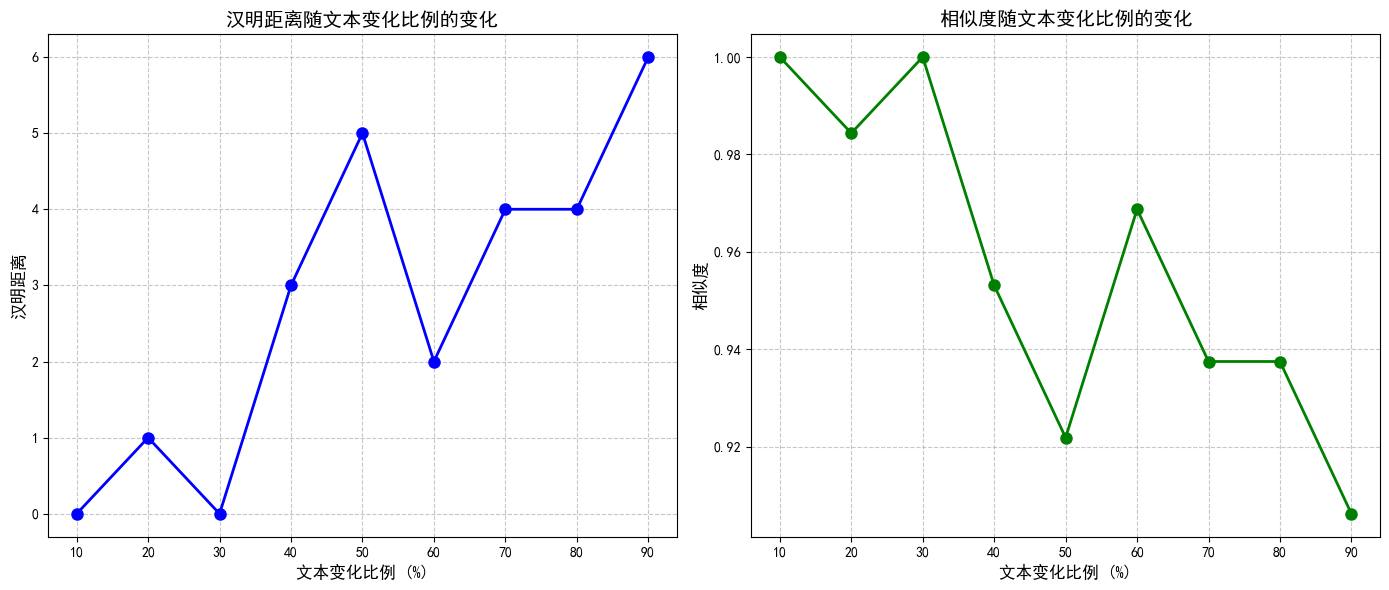

In [27]:
# 设置simhei字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体
plt.rcParams['axes.unicode_minus'] = False  # 显示负号
# 设置图表
plt.figure(figsize=(14, 6))

# 绘制汉明距离随变化比例的变化
plt.subplot(1, 2, 1)
plt.plot(change_percentages, hamming_distances, 'o-', color='blue', linewidth=2, markersize=8)
plt.title('汉明距离随文本变化比例的变化', fontsize=14)
plt.xlabel('文本变化比例 (%)', fontsize=12)
plt.ylabel('汉明距离', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(change_percentages)

# 绘制相似度随变化比例的变化
plt.subplot(1, 2, 2)
plt.plot(change_percentages, similarities, 'o-', color='green', linewidth=2, markersize=8)
plt.title('相似度随文本变化比例的变化', fontsize=14)
plt.xlabel('文本变化比例 (%)', fontsize=12)
plt.ylabel('相似度', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(change_percentages)

plt.tight_layout()
plt.show()

## 12. SimHash的优化与改进

我们已经实现了基本的SimHash算法，但还可以通过以下方式进行优化：

In [ ]:
# 使用TF-IDF权重而非简单词频
def calculate_tfidf_weights(document_features, all_documents_features):
    """
    计算TF-IDF权重
    
    参数:
    - document_features: 当前文档的特征列表
    - all_documents_features: 所有文档的特征列表的列表
    
    返回:
    - 特征到TF-IDF权重的映射字典
    """
    # 计算TF (词频)
    tf = Counter(document_features)
    
    # 计算IDF (逆文档频率)
    num_docs = len(all_documents_features)
    idf = {}
    
    # 统计包含每个特征的文档数
    for feature in set(document_features):
        doc_count = sum(1 for doc_features in all_documents_features if feature in doc_features)
        idf[feature] = np.log(num_docs / (1 + doc_count))
    
    # 计算TF-IDF
    tfidf = {}
    doc_length = len(document_features)
    for feature, freq in tf.items():
        tf_value = freq / doc_length  # 归一化的TF值
        tfidf[feature] = tf_value * idf.get(feature, 0)
    
    return tfidf

In [ ]:
# 使用特征提取的优化版本
def enhanced_extract_features(text, use_tfidf=False, all_documents=None, use_ngram=False, ngram_size=3):
    """
    优化版本的特征提取，可以使用TF-IDF
    
    参数:
    - text: 输入文本
    - use_tfidf: 是否使用TF-IDF权重
    - all_documents: 所有文档的列表，用于计算IDF
    - use_ngram: 是否使用n-gram
    - ngram_size: n-gram的大小
    
    返回:
    - 特征列表和权重字典
    """
    # 提取特征
    features = extract_features(text, use_ngram, ngram_size)
    
    # 如果使用TF-IDF且提供了所有文档
    if use_tfidf and all_documents is not None:
        all_features = [extract_features(doc, use_ngram, ngram_size) for doc in all_documents]
        weights = calculate_tfidf_weights(features, all_features)
    else:
        weights = calculate_weights(features)
    
    return features, weights

## 13. 优化版SimHash测试

In [ ]:
# 以第一组文档为例，使用TF-IDF权重
all_documents = documents
enhanced_doc_hashes = []

for i, doc in enumerate(documents):
    features, weights = enhanced_extract_features(doc, use_tfidf=True, all_documents=all_documents, use_ngram=True)
    doc_hash = simhash(features, weights)
    enhanced_doc_hashes.append(doc_hash)
    print(f"文档 {i} 的增强SimHash: {bin(doc_hash)[2:].zfill(64)[:16]}...（省略）")

In [ ]:
# 测试新文档的相似度检测
new_doc = "这是一篇讨论机器学习最新进展的文章。"
new_features, new_weights = enhanced_extract_features(new_doc, use_tfidf=True, all_documents=all_documents + [new_doc], use_ngram=True)
new_hash = simhash(new_features, new_weights)

print(f"新文档: {new_doc}")
print(f"新文档的增强SimHash: {bin(new_hash)[2:].zfill(64)[:16]}...（省略）")

# 检测相似文档
print("相似文档:")
for i, doc_hash in enumerate(enhanced_doc_hashes):
    distance = hamming_distance(new_hash, doc_hash)
    similarity = calculate_similarity(new_hash, doc_hash)
    if distance <= 3:  # 汉明距离阈值为3
        print(f"文档 {i}: '{documents[i]}'")
        print(f"  汉明距离: {distance}, 相似度: {similarity:.4f}")

## 14. 总结与结论

1. **SimHash算法特点**:
   - SimHash是一种局部敏感哈希算法，能将任意长度的文本映射为固定长度的二进制指纹。
   - 相似文本的SimHash指纹之间汉明距离较小，不相似文本之间汉明距离较大。
   
2. **实现要点**:
   - 分词和特征提取是SimHash算法的关键步骤，对结果有重要影响。
   - 特征权重计算方法（如简单词频或TF-IDF）会影响最终的哈希值。
   - 哈希位数和汉明距离阈值需要根据实际应用场景调整。

3. **应用场景**:
   - 大规模文本查重，如网页去重、新闻聚类、抄袭检测等。
   - 相似文档快速检索。

4. **性能与准确性**:
   - SimHash计算速度快，内存占用少，适合处理大规模文本数据。
   - 通过调整参数和优化算法，可以在性能和准确性之间取得良好平衡。

5. **优化方向**:
   - 更好的特征提取方法，如使用语义相关的特征。
   - 更精确的权重计算，如使用TF-IDF或其他语义权重。
   - 哈希函数的选择对结果也有影响，可以尝试不同的哈希函数。